In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [2]:
sns.set_context('talk')

# Load data

In [3]:
df = pd.read_csv('data/train.csv').set_index('customer')

In [4]:
del_columns = ['category', 'nationality', 'is_pep']
for var_ in del_columns:
    df.drop(var_, axis=1, inplace=True)

In [5]:
df['suspicious'].astype(int).sum()

9087

In [6]:
df.head()

,suspicious,turnover,transaction_count,io_ratio,age,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
customer,,,,,,,,,,,,
90000000,0,734958.58,7.0,0.142857,79.0,24.63,124.0,3,6.0,0.128703,215959.85,832.364854
90000001,0,1009400.35,2.0,0.500000,0.0,78.49,79.0,3,1.0,0.635584,53.97,34.752298
90000002,0,11051.68,3.0,0.666667,77.0,35.74,72.0,2,1.0,0.138152,1632.91,17.323031
90000003,0,31193.29,81.0,0.308642,77.0,2.05,95.0,2,2.0,0.333904,3203.10,50.945281
90000004,0,205489.77,1.0,1.000000,39.0,147.53,148.0,4,1.0,0.341578,5626.65,0.000000


# Basic statistics

In [7]:
df.shape

(1000000, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 90000000 to 90999999
Data columns (total 12 columns):
suspicious                 1000000 non-null int64
turnover                   1000000 non-null float64
transaction_count          1000000 non-null float64
io_ratio                   1000000 non-null float64
age                        1000000 non-null float64
inactive_days_average      1000000 non-null float64
inactive_days_max          1000000 non-null float64
n_of_accounts              1000000 non-null int64
distinct_counterparties    1000000 non-null float64
channel_risk               1000000 non-null float64
atm_withdrawal             1000000 non-null float64
atm_deposit                1000000 non-null float64
dtypes: float64(10), int64(2)
memory usage: 99.2 MB


In [9]:
df.describe()

,suspicious,turnover,transaction_count,io_ratio,age,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
count,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06
mean,0.009087,1.450642e+07,22.981850,0.320689,36.296229,46.324001,114.918432,1.998244,5.219878,0.250848,1.630698e+06,5.161569e+04
std,0.094892,2.690569e+08,45.088017,0.311637,24.382972,52.828032,78.862679,0.998493,13.226557,0.167269,1.087247e+08,1.430538e+06
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.120000,1.000000,1.000000,0.000000,0.000023,0.000000e+00,0.000000e+00
25%,0.000000,4.102706e+04,1.000000,0.000000,18.000000,6.780000,71.000000,1.000000,1.000000,0.123844,1.581900e+02,1.079470e+01
50%,0.000000,1.551433e+05,3.000000,0.294118,38.000000,29.600000,95.000000,2.000000,1.000000,0.217197,3.318705e+03,1.825819e+02
75%,0.000000,4.616345e+05,24.000000,0.477273,56.000000,65.710000,133.000000,3.000000,3.000000,0.342783,2.515866e+04,1.188573e+03
max,1.000000,7.968697e+10,1064.000000,1.000000,131.000000,1376.590000,1440.000000,10.000000,670.000000,0.997642,7.968697e+10,4.004989e+08


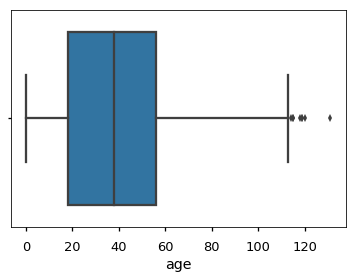

In [10]:
sns.boxplot(df['age'])

# Create balanced dataset

In [50]:
cases_susp = df[df['suspicious']==1]
cases_susp = cases_susp.append(cases_susp.loc[np.random.choice(cases_susp.index, 3*cases_susp.shape[0], replace=True)])
cases_norm = df[df['suspicious']==0].sample(n=1*cases_susp.shape[0])
print(cases_susp.shape, cases_norm.shape)

(36348, 12) (36348, 12)


In [51]:
df_bal = pd.concat([cases_norm, cases_susp])
df_bal.shape

(72696, 12)

# Model

In [52]:
test_features = pd.read_csv('data/test.csv').set_index('customer')

In [53]:
for var_ in del_columns:
    test_features.drop(var_, axis=1, inplace=True)

In [54]:
test_features.shape

(1000000, 11)

## Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

### Train

In [56]:
sub = df_bal  #.sample(n=100)

In [57]:
X = sub.drop('suspicious', axis=1)
y = sub['suspicious']

In [58]:
X.shape

(72696, 11)

#### Create pipeline

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=1000, n_jobs=2, verbose=1))
])

#### Splitting

In [61]:
skf = StratifiedKFold(n_splits=5)

In [62]:
%%time
for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    
    print(report)

A Jupyter Widget

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   21.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   38.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   48.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.7s finished


             precision    recall  f1-score   support

          0       0.98      0.91      0.94      7270
          1       0.92      0.98      0.95      7270

avg / total       0.95      0.95      0.95     14540



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   22.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   39.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   49.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.8s finished


             precision    recall  f1-score   support

          0       0.98      0.92      0.95      7270
          1       0.93      0.99      0.95      7270

avg / total       0.95      0.95      0.95     14540



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   23.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   40.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   50.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.8s finished


             precision    recall  f1-score   support

          0       1.00      0.91      0.95      7270
          1       0.92      1.00      0.96      7270

avg / total       0.96      0.96      0.96     14540



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   23.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   43.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   54.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.8s finished


             precision    recall  f1-score   support

          0       1.00      0.91      0.96      7269
          1       0.92      1.00      0.96      7269

avg / total       0.96      0.96      0.96     14538



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   39.8s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   50.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.3s


             precision    recall  f1-score   support

          0       1.00      0.91      0.95      7269
          1       0.92      1.00      0.96      7269

avg / total       0.96      0.96      0.96     14538


CPU times: user 8min 34s, sys: 7.26 s, total: 8min 41s
Wall time: 4min 25s


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.7s finished


#### Final

In [24]:
%%time
clf.fit(X, y)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   14.1s


CPU times: user 33.4 s, sys: 707 ms, total: 34.1 s
Wall time: 18.1 s


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   17.4s finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=2,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False))])

### Test

In [ ]:
sub_test = test_features  # [['nationality', 'atm_withdrawal']]
sub_test.shape

In [ ]:
%%time
predictions = clf.predict_proba(sub_test)

In [ ]:
# sort by `suspicious` probability
df_pred = pd.DataFrame(
    predictions,
    columns=['normal_prob', 'suspicious_prob'],
    index=sub_test.index
).sort_values(by='suspicious_prob', ascending=False)
df_pred.head()

In [ ]:
N = 1000
idx = df_pred['suspicious_prob'].head(N).index
fraud_rows = test_features.loc[idx]

In [ ]:
(pd.Series(fraud_rows.index)
 .to_frame()
 .to_csv('fraudulent_customers.txt', index=False))

In [ ]:
sns.distplot(df_pred['suspicious_prob'], kde=False)
plt.ylabel('Count')